# Dropout prevents over-learning
### ดรอปเอาต์ คือการสร้างชั้นกรองชั้นหนึ่งสำหรับสุ่มเลือกให้ข้อมูลจากเซลล์ประสาทแค่บางเซลล์เท่านั้นผ่านไปได้
![DO](https://phyblas.hinaboshi.com/rup/nayuki/umaki/q01.png)
## ในแต่ละรอบของการฝึกเรียนรู้จะสุ่มเลือกไม่ซ้ำกัน ทำให้แต่ละรอบโครงข่ายใช้คนละเซลล์กันในการคำนวณ
![DO2](https://phyblas.hinaboshi.com/rup/nayuki/umaki/q02.png)

### เพียงแต่ว่าการสุ่มเอาเซลล์ออกนี้จะทำเฉพาะตอนที่กำลังฝึกแบบจำลองอยู่เท่านั้น แต่ตอนที่ใช้งานเพื่อทำการทำนายจริงๆจะเปิดใช้หมดทุกเซลล์พร้อมกัน
## ชั้นดรอปเอาต์จะวางไว้ที่ก่อนหรือหลังชั้นฟังก์ชันกระตุ้นในแต่ละชั้นก็ได้
# ตัวอย่างผังโครงสร้างเพอร์เซปตรอน ๔ ชั้น
![Structor](https://phyblas.hinaboshi.com/rup/nayuki/umaki/q03.png)

### ที่จริงแล้วแนวคิดของดรอปเอาต์นั้นเหมือนกับเทคนิคที่เรียกว่าการเรียนรู้แบบอ็องซ็องบล์ ***(ensemble learning)*** ซึ่งเป็นวิธีการที่สร้างแบบจำลองสำหรับทำนายขึ้นมาหลายๆตัวแล้วให้เรียนรู้ข้อมูลเดียวกัน แล้วสุดท้ายเวลาทำนายก็เอาแบบจำลองเหล่านี้มาพิจารณาร่วมกัน ซึ่งจะได้ประสิทธิภาพมากกว่าการพิจารณาด้วยแบบจำลองตัวเดียว
# สำหรับโครงข่ายประสาทเทียม แค่สร้างชั้นดรอปเอาต์ขึ้นก็มีผลเทียบเท่ากับการเรียนรู้แบบอ็องซ็องบล์แล้ว 
### ชั้นของดรอปเอาต์จะต้องมีการแยกกรณีระหว่างตอนที่ฝึกกับตอนที่ใช้งานจริง เพราะตอนที่ฝึกจะให้ข้อมูลผ่านแค่บางส่วน แต่ตอนใช้งานจริงจะให้ไหลทั้งหมด


In [3]:
import sys
sys.path.insert(1, '../../Side Stories/')
from unagi import Chan, ha_1h, Affin, Relu, Softmax_entropy, Adam

In [4]:
import numpy as np
class Dropout(Chan):
    def __init__(self, drop=.5):
        self.drop = drop
        self.is_training = 1
        
    def pai(self, x):
        if (self.is_training):
            self.filter = np.random.rand(*x.shape) > self.drop
            return x*self.filter
        else:
            return x*(1-self.drop)
    def yon(self, g):
        return g*self.filter

#### ค่า .train มีไว้แบ่งกรณีว่ากำลังอยู่ในโหมดฝึกอยู่หรือเปล่า ถ้าฝึกอยู่จะมีค่าเป็น 1 และจะมีการกรองเพื่อตัดค่าขาเข้าส่วนหนึ่งทิ้งไป ถ้าไม่ได้ฝึกอยู่ก็จะมีค่าเป็น 0 ก็จะไม่มีการกรองแต่ปล่อยให้ค่าทั้งหมดไหลผ่านไป

In [5]:
class Prasat:
    def __init__(self,m,eta=0.001,drop=0):
        self.m = m
        self.chan = []
        for i in range(len(m)-1):
            self.chan.append(Affin(m[i],m[i+1],np.sqrt(2./m[i])))
            if(i<len(m)-2):
                if(drop): # ใส่ดรอปเอาต์ทุกชั้นยกเว้นชั้นสุดท้าย
                    self.chan.append(Dropout(drop))
                self.chan.append(Relu())
        self.chan.append(Softmax_entropy())
        self.opt = Adam(self.param(),eta=eta)
    
    def rianru(self,X,z,X_truat,z_truat,n_thamsam=100):
        Z = ha_1h(z,self.m[-1])
        self.khanaen_fuek = []
        self.khanaen_truat = []
        for o in range(n_thamsam):
            entropy = self.ha_entropy(X,Z)
            entropy.phraeyon()
            self.opt()
            khanaen_fuek = self.ha_khanaen(X,z)
            khanaen_truat = self.ha_khanaen(X_truat,z_truat)
            self.khanaen_fuek.append(khanaen_fuek)
            self.khanaen_truat.append(khanaen_truat)
            if(o%100==99):
                print(u'ผ่านไป %d รอบ, ทำนายข้อมูลฝึกแม่น=%.2f, ทำนายข้อมูลตรวจสอบแม่น=%.2f'%(o+1,khanaen_fuek,khanaen_truat))
    
    def ha_entropy(self,X,Z,fuekyu=1):
        for c in self.chan[:-1]:
            c.fuekyu = fuekyu
            X = c(X)
        return self.chan[-1](X,Z)
    
    def param(self):
        p = []
        for c in self.chan:
            if(hasattr(c,'param')):
                p.extend(c.param)
        return p
    
    def thamnai(self,X,fuekyu=0):
        for c in self.chan[:-1]:
            c.fuekyu = fuekyu
            X = c(X)
        return X.kha.argmax(1)
    
    def ha_khanaen(self,X,z):
        return (self.thamnai(X)==z).mean()

ผ่านไป 100 รอบ, ทำนายข้อมูลฝึกแม่น=0.89, ทำนายข้อมูลตรวจสอบแม่น=0.81
ผ่านไป 200 รอบ, ทำนายข้อมูลฝึกแม่น=0.99, ทำนายข้อมูลตรวจสอบแม่น=0.83
ผ่านไป 300 รอบ, ทำนายข้อมูลฝึกแม่น=1.00, ทำนายข้อมูลตรวจสอบแม่น=0.81
ผ่านไป 400 รอบ, ทำนายข้อมูลฝึกแม่น=1.00, ทำนายข้อมูลตรวจสอบแม่น=0.78
ผ่านไป 500 รอบ, ทำนายข้อมูลฝึกแม่น=1.00, ทำนายข้อมูลตรวจสอบแม่น=0.78
ผ่านไป 600 รอบ, ทำนายข้อมูลฝึกแม่น=1.00, ทำนายข้อมูลตรวจสอบแม่น=0.79
ผ่านไป 100 รอบ, ทำนายข้อมูลฝึกแม่น=0.81, ทำนายข้อมูลตรวจสอบแม่น=0.74
ผ่านไป 200 รอบ, ทำนายข้อมูลฝึกแม่น=0.91, ทำนายข้อมูลตรวจสอบแม่น=0.77
ผ่านไป 300 รอบ, ทำนายข้อมูลฝึกแม่น=0.97, ทำนายข้อมูลตรวจสอบแม่น=0.75
ผ่านไป 400 รอบ, ทำนายข้อมูลฝึกแม่น=0.95, ทำนายข้อมูลตรวจสอบแม่น=0.77
ผ่านไป 500 รอบ, ทำนายข้อมูลฝึกแม่น=0.96, ทำนายข้อมูลตรวจสอบแม่น=0.79
ผ่านไป 600 รอบ, ทำนายข้อมูลฝึกแม่น=0.95, ทำนายข้อมูลตรวจสอบแม่น=0.78


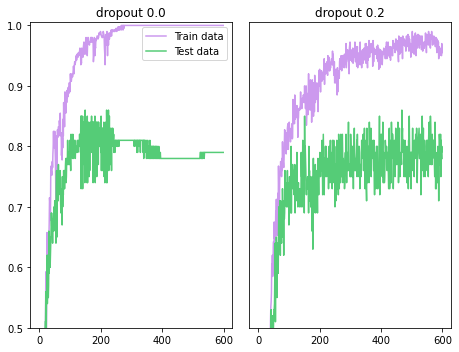

In [7]:
import matplotlib.pyplot as plt
from glob import glob

uri = '../../SAMPLE DATA/ruprang-raisi-25x25x1000x5/*/*1.png'
# โหลดเฉพาะรูปที่ชื่อลงท้ายด้วยเลข 1 ซึ่งมีอยู่ 1/10 ของรูปทั้งหมด
X = np.array([plt.imread(x) for x in sorted(glob(uri))])
X = X.reshape(-1,25*25)
z = np.arange(5).repeat(100)
n = len(z) # จำนวนข้อมูลทั้งหมด

n_fuek = int(n*0.8) # จำนวนข้อมูลฝึกเป็น 4 ใน 5
np.random.seed(9)
sumlueak = np.random.permutation(n)
X_fuek,X_truat = X[sumlueak[:n_fuek]],X[sumlueak[n_fuek:]]
z_fuek,z_truat = z[sumlueak[:n_fuek]],z[sumlueak[n_fuek:]]

plt.figure(figsize=[6.5,5])
for drop in [0,1]:
    plt.subplot(1,2,1+drop,ylim=[0.5,1.005])
    drop *= 0.2
    prasat = Prasat(m=[625,100,100,100,6],drop=drop)
    prasat.rianru(X_fuek,z_fuek,X_truat,z_truat,n_thamsam=600)
    plt.plot(prasat.khanaen_fuek,'#cc99ee')
    plt.plot(prasat.khanaen_truat,'#55cc77')
    plt.title(u'dropout %.1f'%drop,size=12)
    if(drop==0):
        plt.legend(['Train data', 'Test data'],)
    else:
        plt.yticks([])
plt.tight_layout()
plt.show()